# Tensorflow

## Handwriting recognition

The standard example for machine learning these days is the MNIST data set, a collection of 70,000 handwriting samples of the numbers 0-9. Our challenge - to predict which number each handwritten image represents.

Each image is 28x28 grayscale pixels, so can treat each image as just a 1D array, or tensor, of 784 numbers. As long as consistent in how flatten each image into an array, it'll still work.

Importing the data set, which conveniently is part of tensorflow itself. Then, reshape the images into the 1D arrays of 784 pixels that we expect, and the label data into one-hot-encoded categorical format (which will convert during our loss function defination):

In [15]:
# Prepare MNIST data.
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# MNIST dataset parameters
num_classes = 10 # total classes (0-9 digits)
num_features = 784 # data features (img shape: 28*28)

# load dataset of handwriting samples
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert to float32 (tensorflow expects this)
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Flatten images to 1-D vector of 784 features (28*28)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize images value from [0, 255] to [0, 1]
x_train, x_test = x_train / 255., x_test / 255.

MNIST provides 60,000 samples in a training data set, and 10,000 samples in a test data set.

Use a completely different set of images to train our neural network from the images used for testing its accuracy.

The training images are therefore a tensor of shape [60,000, 784] - 60,000 instances of 784 numbers that represent each image. The training labels are a one-dimensional tensor of 60,000 labels that range from 0 to 9.

Define a little function to visualize what the input data looks like, and pick some random training image.

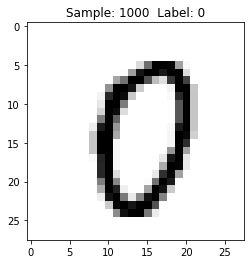

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

# method to visualize
def display_sample(num):
    
    #Print this sample's label 
    label = y_train[num] 
    
    #Reshape the 784 values to a 28x28 image
    image = x_train[num].reshape([28,28])
    
    # show the gray scale
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(1000)

The training label for image #1000, as well as what this particular sample looks like.

Flattening each image to a 1D array of 784 (28 x 28) numerical values. Each one of those values will be an input node into our deep neural network. 

Visualize how the data is being fed into it just to drive that point home:

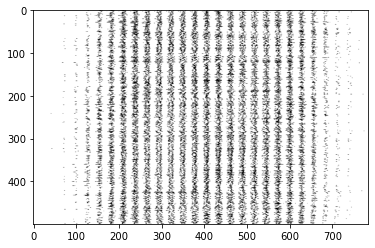

In [17]:
# reshape back down to 1d arrays
images = x_train[0].reshape([1,784])

# first 500 training images
for i in range(1, 500):
    
    # flatten them down to 784 pixel values
    images = np.concatenate((images, x_train[i].reshape([1,784])))
    
# shows images
plt.imshow(images, cmap=plt.get_cmap('gray_r'))
plt.show()

This is showing the first 500 training samples, one on each row. Each pixel on each row getting fed into the bottom layer of a neural network 768 neurons (or "units") wide as train our neural network.

Define few training parameters (or "hyperparameters") and use tf.data API to shuffle the data and divide it into batches. 

Use a Dataset within Tensorflow to wrap traning features and labels, and use functions of the Dataset to randomly shuffle it and batch it up into smaller chunks for each iteration of training.

In [18]:
# Training parameters.
learning_rate = 0.001 # how quickly it descends through gradient descend
training_steps = 3000 # how many training steps
batch_size = 250 # how many random samples from trianing datta
display_step = 100 # how often to display progress

# Network parameters.
n_hidden = 512 # Number of neurons.

In [19]:
# Use tf.data API to shuffle and batch data.
# reate dataset obj
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# create individual batches
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

Setting up that artificial neural network by creating variables to store and keep track of weights and biases of different layers.

Need an input layer with one node per input pixel per image, or 784 nodes. That will feed into a hidden layer of some arbitrary size - let's pick 512, given by n_hidden. That hidden layer will output 10 values, given by num_classes, corresonding to scores for each classification to be fed into softmax.

In [20]:
# Store layers weight & bias

# A random value generator to initialize weights initially
random_normal = tf.initializers.RandomNormal()

# define weights randomly: 512 vars that contain weights for neurons
weights = {
    'h': tf.Variable(random_normal([num_features, n_hidden])),
    'out': tf.Variable(random_normal([n_hidden, num_classes]))
}

# want biases to be 0 by default
biases = {
    'b': tf.Variable(tf.zeros([n_hidden])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

Set up the neural network itself by feeding input data into the first layer of our neural network. All this layer does is multiply these inputs by our weight "h" tensor which will be learned over time.

Then feed that into our hidden layer, which applies the sigmoid activation function to the weighted inputs with our learned biases added in as well.

Finally the output layer, called out_layer, multiplies in the learned weights of the hidden layer and adds in the hidden layer's bias term.

In [21]:
# Create model.
def neural_net(inputData):
    
    # Hidden fully connected layer with 512 neurons.
    hidden_layer = tf.add(tf.matmul(inputData, weights['h']), biases['b'])
    
    # Apply sigmoid to hidden_layer output for non-linearity.
    hidden_layer = tf.nn.sigmoid(hidden_layer)
    
    # Output fully connected layer with a neuron for each class.
    out_layer = tf.matmul(hidden_layer, weights['out']) + biases['out']
    
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out_layer)

his sets up a deep neural network like:

output layer

hidden layer

input layer

Define the loss function for use in measuring our progress in gradient descent: cross-entropy, which applies a logarithmic scale to penalize incorrect classifications much more than ones that are close. In this function,  y_pred is the output of our final layer, and comparing that against the target labels used for training in y_true.

To compare the known "true" labels of 0-9 to the output of our neural network, need to convert the labels to "one-hot" encoding. The output layer has a neuron for each possible label of 0-9, not a single neuron with an integer in it. 

For example, a known "true" label for an image is 1, would represent that in one-hot format as [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] This makes it easier to compare the known label to the output neurons.

In [22]:
# reduce into one sum value
def cross_entropy(y_pred, y_true):
    
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1
                              
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

SyntaxError: invalid syntax (<ipython-input-22-72ab95550545>, line 11)

Set up stocastic gradient descent optimizer, based on previously defined hyperparameters and loss function defined above.

In [0]:
# run optimizer using learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate)

# update vars, update weights to compute new weights and biases
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

Train our neural network and measure its accuracy. First, define some methods for measuring the accuracy of trained model. 

correct_prediction will look at the output of neural network (in digit_weights) and choose the label with the highest value, and see if that agrees with the target label given. During testing, digit_weights will be the prediction based on the test data given tothe network, and target_labels is a placeholder that we will assign to test labels. Ultimately this gives a 1 for every correct classification, and a 0 for every incorrect classification.

"accuracy" then takes the average of all the classifications to produce an overall score for model's accuracy.

In [0]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

Can train our network in 3000 steps (or "epochs", given by training_steps) with batches of 250 samples set up earlier in training data. At each step, assign run optimization function on the current batch of images and labels from the training data.

At every 100 epochs (given by display_step), print out the current values of the loss function and accuracy metric, by comparing predicted labels against the known "true" labels. To do this, run neural network using trained weights and biases at each point on the current batch of training images, and compute cross entropy and accuracy of the resulting predictions ("pred") to the known correct labels ("batch_y").

In [0]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    
    # Run the optimization to update W and b values.
    # take a batch, run oprimization on it
    run_optimization(batch_x, batch_y)
    
    # at every 100 steps
    if step % display_step == 0:
        pred = neural_net(batch_x) # execute nn on current batch to get predictions
        loss = cross_entropy(pred, batch_y) # current loss funciton snapshot
        acc = accuracy(pred, batch_y) # current accuracy
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

In [0]:
# Test model on validation set.
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

About 93% accuracy. 

Look at some of the misclassified images and see just how good or bad our model is, compared to what our own brain can do. 

Go through the first 200 test images and look at the ones that are misclassified:

In [0]:
n_images = 200 # first 200 test images
test_images = x_test[:n_images] 
test_labels = y_test[:n_images] 
predictions = neural_net(test_images) 

# for every test image
for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray_r')
        plt.show()
        print("Original Labels: %i" % test_labels[i])
        print("Model prediction: %i" % model_prediction)